# Nodal cycle

Invetigate the source of nodal cycle along the Dutch coast. Compare the observed nodal cycle, the equilibrium tide and the nodal cycle influence on steric sea level.

In [71]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial

import SeaLevelContrib as slc

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Import data from GAM model study

In [22]:
gam = pd.read_csv("~/Projects/NetherlandsSeaLevelAcceleration/outputs/results_NearestPointAverage.csv")
gam.set_index("time", inplace=True)

obs_nod = gam["nod1"]+gam["nod2"]
obs_nod.name = "Observed cycle"
gam

,nod1,nod2,u2_mean,trend,total,total_nodal,total_wind,rate_slr
time,,,,,,,,
1890,1.188413,0.000000,1.222790,-13.736928,-11.325725,1.188413,1.222790,NaN
1891,1.121341,0.273279,2.541637,-13.567537,-9.631281,1.394620,2.541637,1.693111
1892,0.927698,0.515711,0.583258,-13.398305,-11.371638,1.443409,0.583258,1.690601
1893,0.629341,0.699932,2.826477,-13.229417,-9.073667,1.329273,2.826477,1.687156
1894,0.259947,0.805148,1.566783,-13.060874,-10.428996,1.065095,1.566783,1.684184
...,...,...,...,...,...,...,...,...
2016,0.144963,-0.818968,3.164772,10.111924,12.602692,-0.674005,3.164772,3.021716
2017,0.527438,-0.739412,7.457205,10.413951,17.659182,-0.211974,7.457205,3.019257
2018,0.850379,-0.576396,1.914408,10.715775,12.904167,0.273984,1.914408,3.017686


## Compute the equilibrium tide

In [32]:
latitude_netherlands = 53

et = slc.nodal_tides_potential(latitude_netherlands, gam.index)
et = et.rename(columns={"Nodal":"Equilibrium tide"})

## Compute the nodal cycle in steric sea level

Try to remove the low frequency variability while keeping the nodal cycle

In [569]:
# Choose maximum depth of integration, region and start year for the analysis
max_depth = 500
region = "EBB"
start_year = 1920

In [570]:


StericSL_EBB_df = slc.StericSL('EN4_22', 'EBB', 0, max_depth, 0)
StericSL_BB_df = slc.StericSL('EN4_22', 'BB', 0, max_depth, 0)
StericSL_NWS_df = slc.StericSL('EN4_22', 'NWS', 0, max_depth, 0)
StericSL_ENS_df = slc.StericSL('EN4_22', 'ENS', 0, max_depth, 0)

StericSL_EBB_df.columns = ["Steric_EBB"]
StericSL_BB_df.columns = ["Steric_BB"]
StericSL_NWS_df.columns = ["Steric_NWS"]
StericSL_ENS_df.columns = ["Steric_ENS"]

StericSL_df = StericSL_EBB_df.join([StericSL_BB_df,StericSL_NWS_df,StericSL_ENS_df])

# Remove the first decades
StericSL_df = StericSL_df.loc[start_year:]

<AxesSubplot: xlabel='time'>

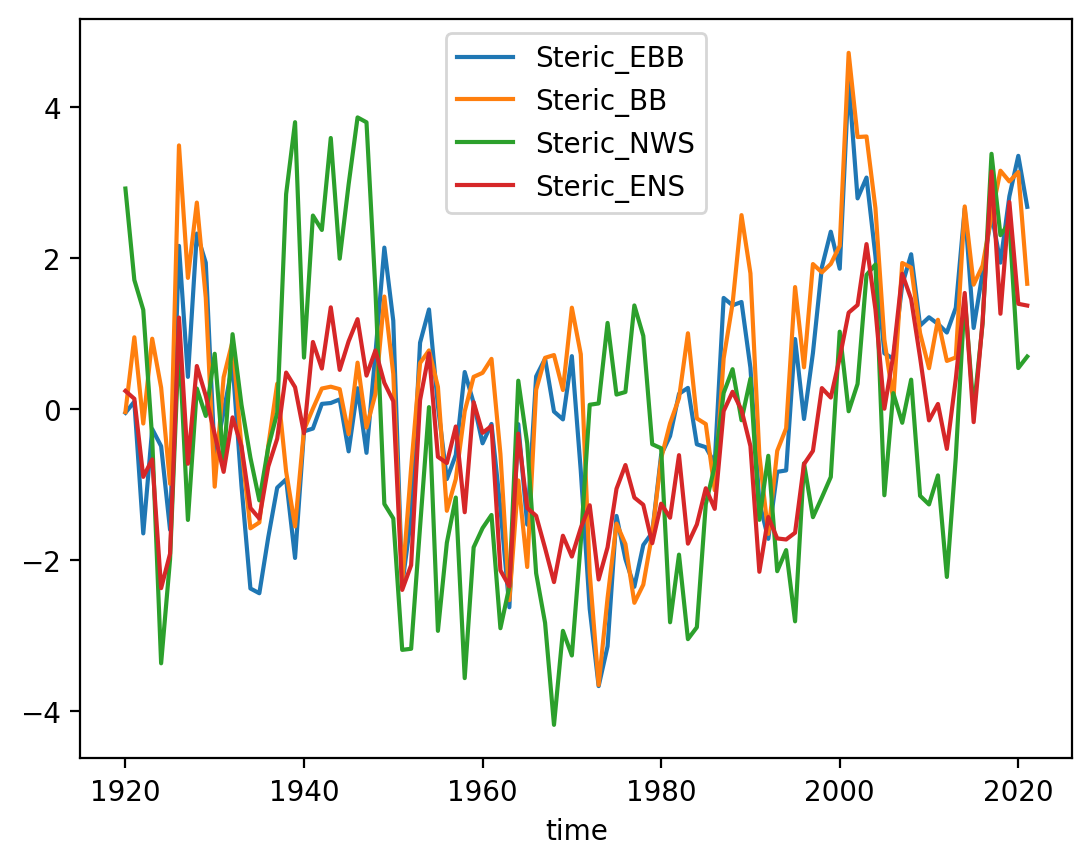

In [571]:
StericSL_df.iloc[:,0:4].plot()


In [572]:
t = StericSL_df.index

reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

In [573]:
reg_df

,Steric,nod1,nod2
time,,,
1920,-0.047776,1.000000,0.000000
1921,0.100612,0.943562,0.331195
1922,-1.643272,0.780620,0.625006
1923,-0.262015,0.529565,0.848270
1924,-0.488746,0.218735,0.975784
...,...,...,...
2017,2.585531,0.240091,0.970750
2018,1.939709,-0.094967,0.995480
2019,2.817520,-0.419305,0.907845


In [574]:
gam_df = len(t)//2
gam_alpha = 5000

In [575]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

def store_results_df(reg_df, res_gam, reg_list):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['nodal_steric'] = model_results_df['nod1'] + model_results_df['nod2']

    return model_results_df

def compute_model(reg_df):
    
    reg_list = ['nod1', 'nod2']
    regression_formula = 'Steric ~ nod1 + nod2'
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list)
    
    return model_results_df, res_gam

In [576]:
res_nr, res_full_nr = compute_model(reg_df)


In [577]:
res_nr

,nod1,nod2,trend,total,nodal_steric
time,,,,,
1920,-0.778078,0.000000,-0.093205,-0.871283,-0.778078
1921,-0.734165,0.103577,-0.109935,-0.740523,-0.630588
1922,-0.607383,0.195463,-0.126561,-0.538481,-0.411920
1923,-0.412043,0.265286,-0.142963,-0.289720,-0.146757
1924,-0.170193,0.305165,-0.159056,-0.024084,0.134972
...,...,...,...,...,...
2017,-0.186809,0.303590,2.248510,2.365291,0.116781
2018,0.073892,0.311324,2.311505,2.696721,0.385216
2019,0.326252,0.283917,2.374294,2.984464,0.610170


### Check the GAM model results

<AxesSubplot: xlabel='time'>

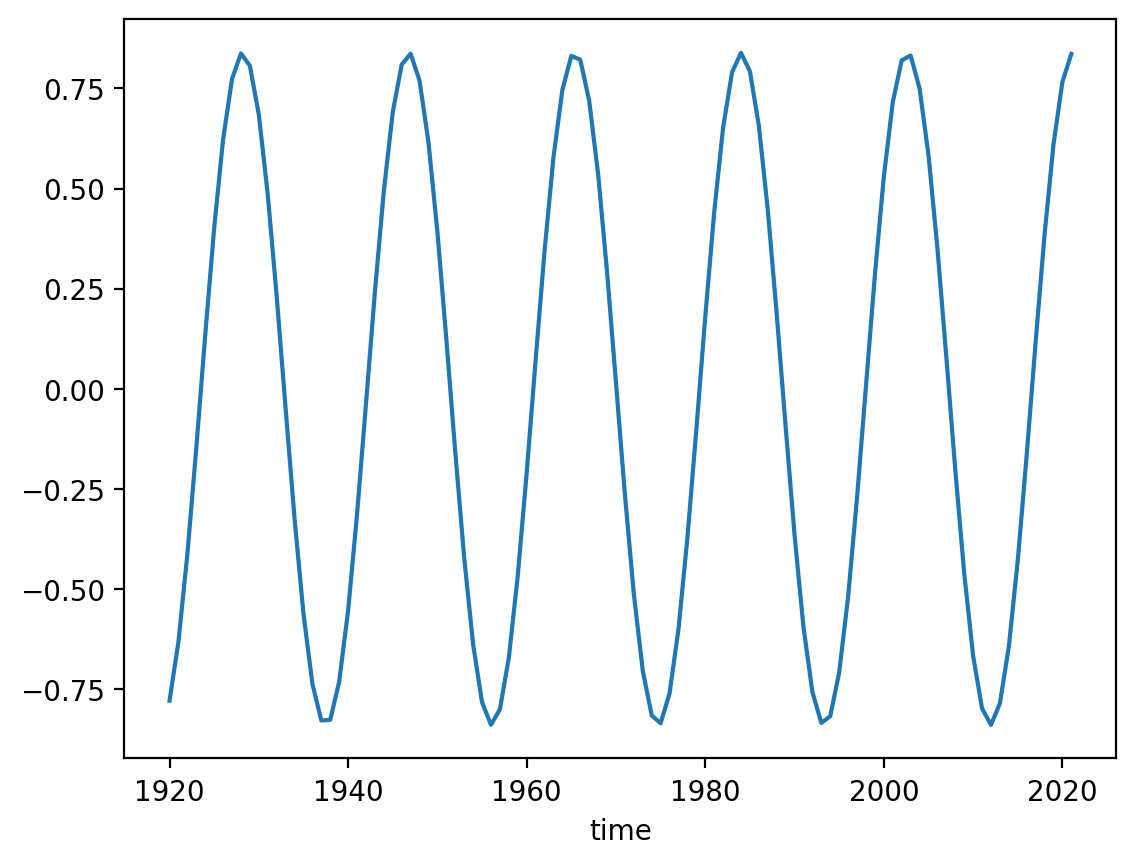

In [578]:
res_nr["nodal_steric"].plot()

In [579]:
max(res_nr["nodal_steric"])

0.8385678849378561

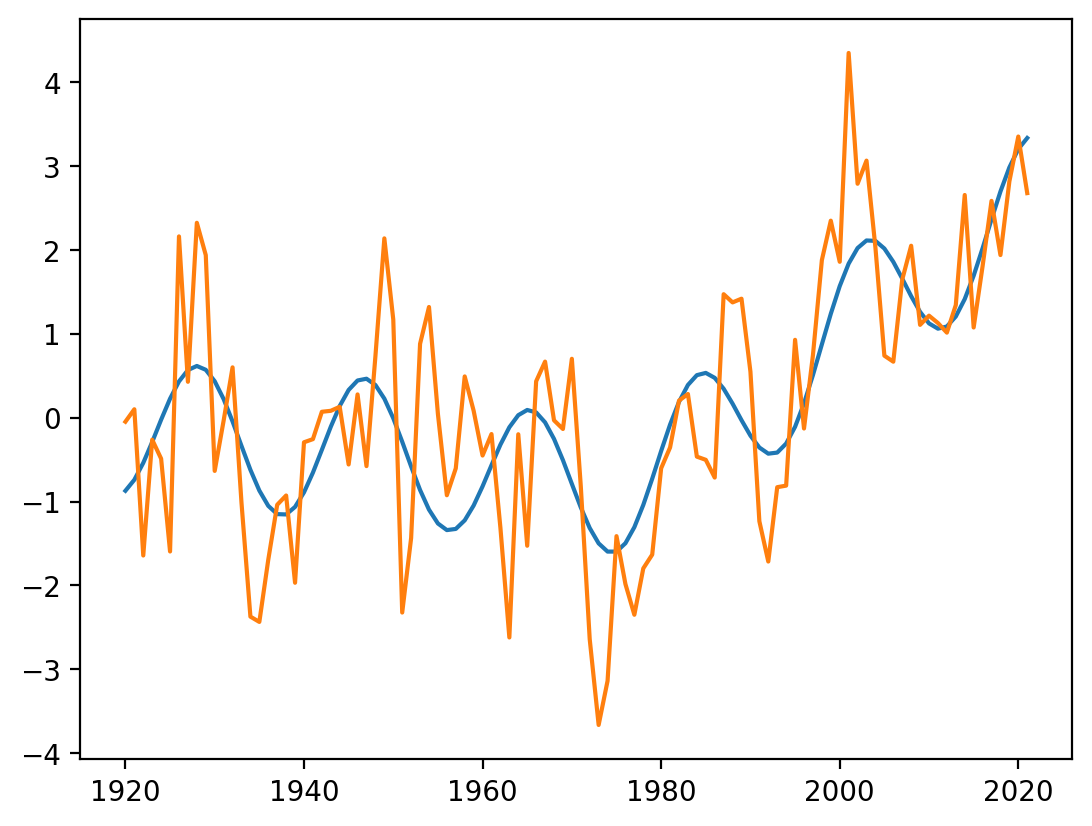

In [580]:
plt.plot(res_nr["total"])
plt.plot(StericSL_df[f"Steric_{region}"])

<AxesSubplot: xlabel='time'>

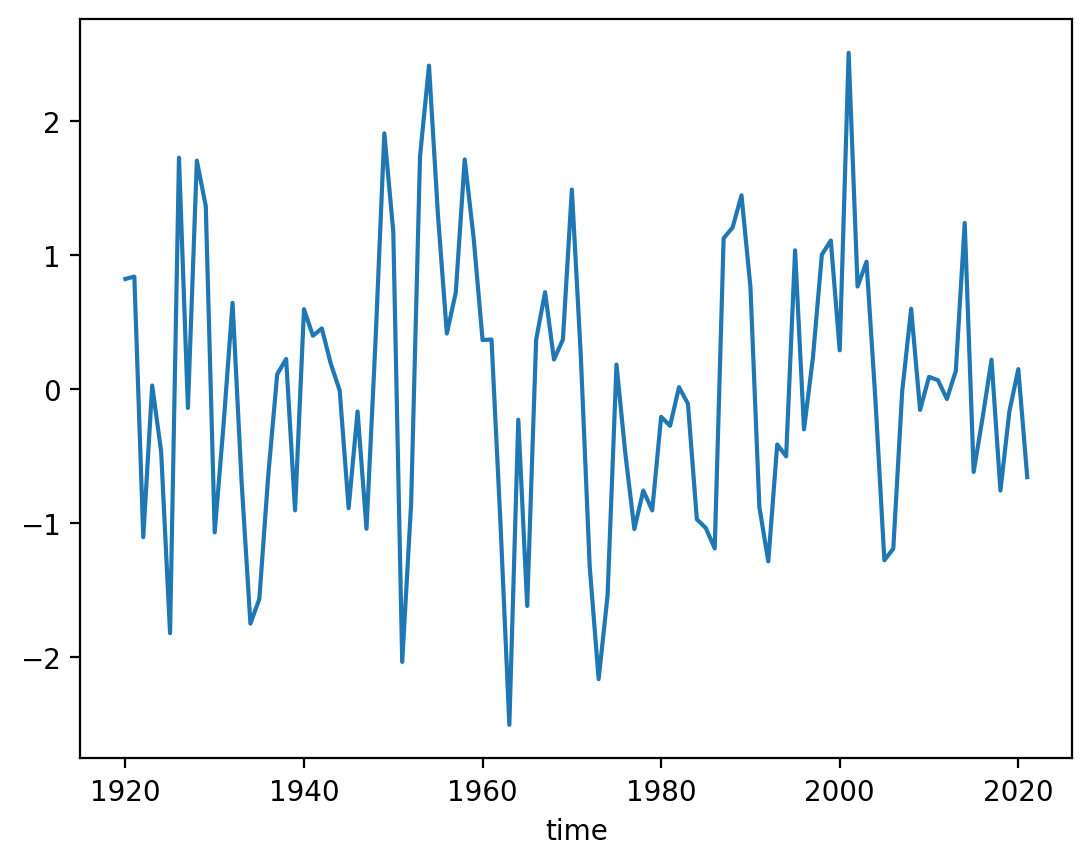

In [581]:
(StericSL_df[f"Steric_{region}"]-res_nr["total"]).plot()

In [582]:
abs(StericSL_df["Steric_EBB"]-res_nr["total"]).sum()

82.67054349734629

## Join the different nodal terms together

In [583]:
nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])

nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]

In [584]:
nodal_df

,Equilibrium tide,Observed cycle,nodal_steric,Eq+Steric
time,,,,
1890,-0.024977,1.188413,NaN,NaN
1891,0.161252,1.394620,NaN,NaN
1892,0.329274,1.443409,NaN,NaN
1893,0.460117,1.329273,NaN,NaN
1894,0.539008,1.065095,NaN,NaN
...,...,...,...,...
2016,-0.556521,-0.674005,-0.164836,-0.721357
2017,-0.509505,-0.211974,0.116781,-0.392724
2018,-0.404960,0.273984,0.385216,-0.019744


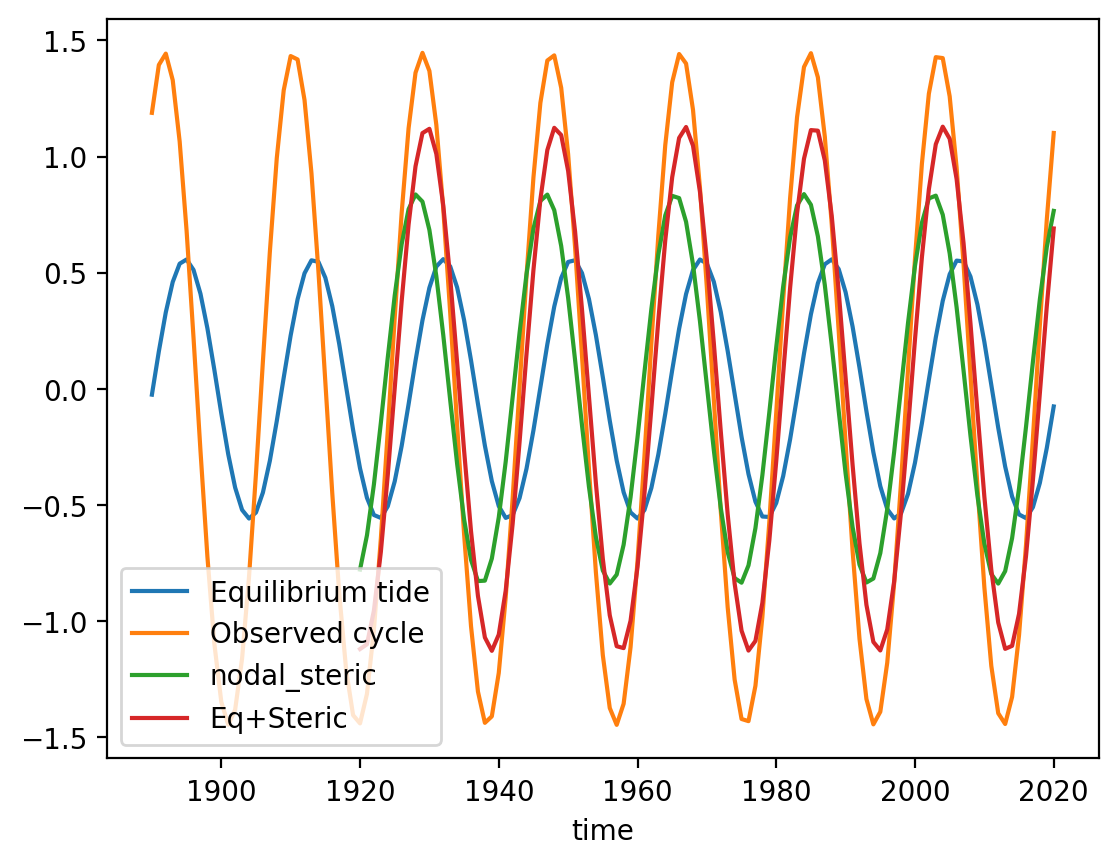

In [585]:
nodal_df.plot()


## Prepare a nice summary figure

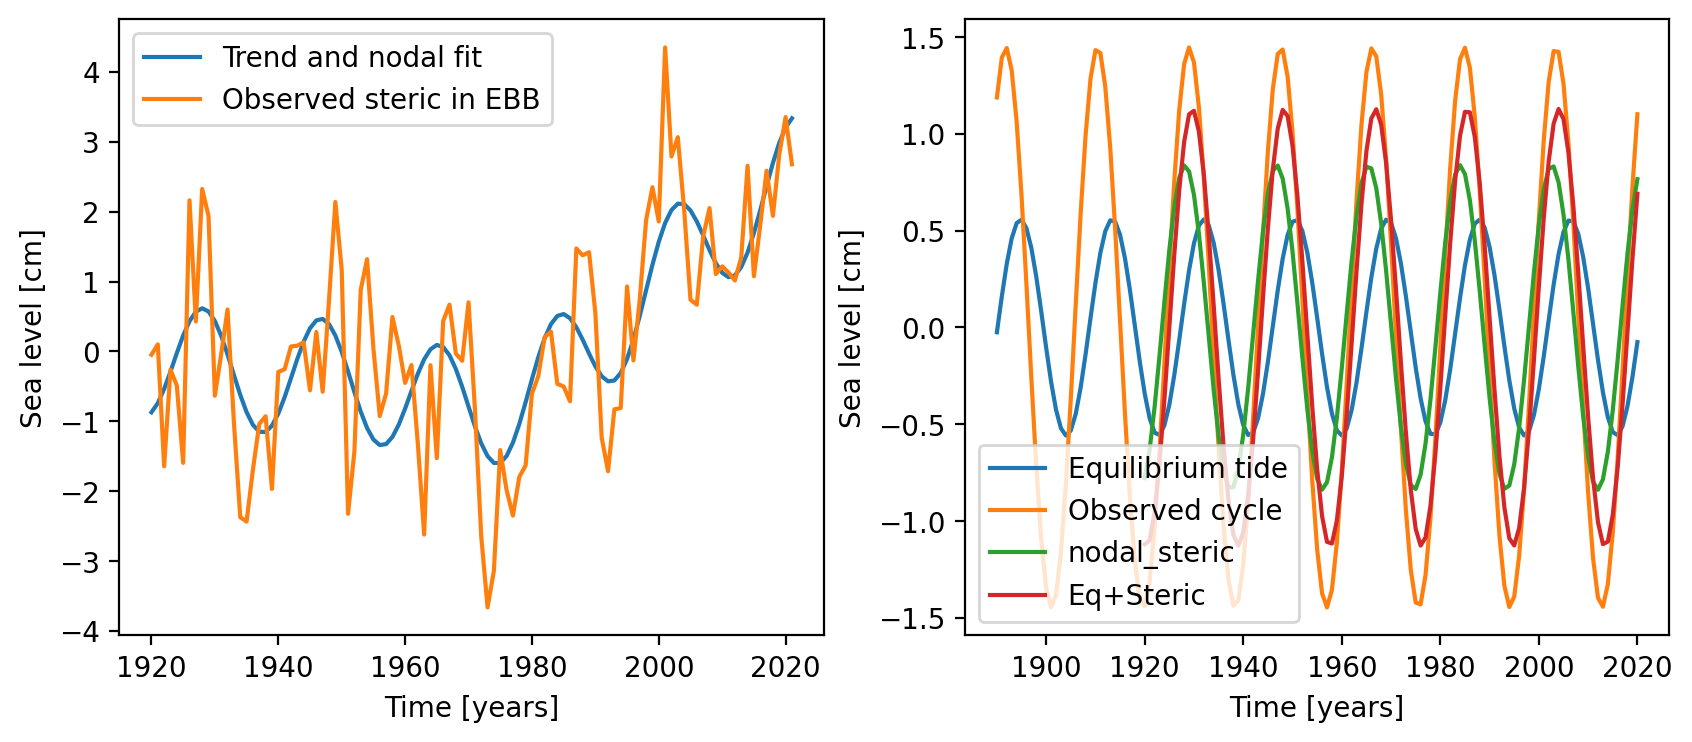

In [599]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))


ax[0].plot(res_nr["total"], label="Trend and nodal fit")
ax[0].plot(StericSL_df[f"Steric_{region}"], label=f"Observed steric in {region}" )

ax[0].legend()

nodal_df.plot(ax=ax[1])

for i in range(2):
    ax[i].set_xlabel("Time [years]")
    ax[i].set_ylabel("Sea level [cm]")

plt.savefig('../figures/NodalCycleNetherlands.pdf', dpi=150)

## Conclusions

For the EBB region the steric signal is largest when integrated over 500 m (amplitude 0.58 cm)

For the NWS region is is largest when integrated over 4000 m (amplitude of 0.74 cm).

ENS region has a smaller magnitude.

Removing the beginning ot the 20th century from the analysis makes the nodal cycle fit larger. This could be because the quality of the observations is not good enough.

The EBB is more in phase with the equilibrium tide so the sum of equilibrium tide and steric nodal cycle is larger for the EBB.
